In [23]:
import os
import re
import subprocess
import glob
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import matplotlib as mpl
from einops import rearrange
import nibabel as nib
from fsl.wrappers import flirt,fslmaths
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [25]:
from fsl.wrappers import flirt, bet
import os

# ========== 配置路径 ==========
mag = "Nifti/SF_map_processing_nii/phj_dic_nii/phj_dic_b0map_tra_20240912143416_202_e2.nii.gz"
brain_mask = "Nifti/SF_map_processing_nii/phj_dic_nii/phj_dic_bet_mask.nii.gz"
mag_brain = "Nifti/SF_map_processing_nii/phj_dic_nii/phj_brain_mag.nii.gz"

mni_t1 = "MNI152_T1_1mm_brain.nii.gz"
mask_mni = "pfc_mask_v3.nii.gz"

mni_in_native = "Nifti/SF_map_processing_nii/phj_dic_nii/registered_MNI152.nii.gz"
xfm_matrix = "Nifti/SF_map_processing_nii/phj_dic_nii/pfc2native.mat"
mask_in_native = "Nifti/SF_map_processing_nii/phj_dic_nii/phj_pfc_mask.nii.gz"

# ========== Step 1: BET 去颅骨处理 ==========
print(">> BET 去颅骨中...")
fslmaths(mag).mul(brain_mask).run(mag_brain)

# ========== Step 2: MNI -> native 配准 ==========
print(">> MNI → MAG 配准中...")
flirt(
    mni_t1,
    mag_brain,
    out=mni_in_native,
    omat=xfm_matrix,
    dof=12,
    cost='mutualinfo'
)

# ========== Step 3: 将 MNI mask 应用到个体空间 ==========
print(">> PFC mask 映射到 native 空间中...")
flirt(
    mask_mni,
    mag_brain,
    out=mask_in_native,
    init=xfm_matrix,
    applyxfm=True,
    interp="nearestneighbour"
)

print("✅ 全部完成：pfc_mask 已注册到 native 空间，脱颅已完成。")


>> BET 去颅骨中...
>> MNI → E2 MAG 配准中...
>> PFC mask 映射到 native 空间中...
✅ 全部完成：pfc_mask 已注册到 native 空间，脱颅已完成。


In [39]:
def batch_register_32ch_deltaB0(root_folder, reference_file):
    """
    Uses magnitude images from subfolder 'negative_nii' for registration,
    then applies transform to deltaFieldmap images.

    Parameters:
        root_folder (str): Path to '32ch_coil_profile_nii' folder.
        reference_file (str): Path to reference NIfTI file (e.g., B0_target.nii.gz).

    Returns:
        list: Paths to all successfully registered deltaFieldmap files.
    """
    if not os.path.exists(reference_file):
        raise FileNotFoundError("❌ Reference file not found.")

    registered_paths = []

    for ch in range(1, 33):
        ch_folder = os.path.join(root_folder, f"ch{ch}_nii")
        if not os.path.isdir(ch_folder):
            print(f"⚠️ Skipping {ch_folder} (not a directory)")
            continue

        negative_folder = os.path.join(ch_folder, "negative_nii")
        if not os.path.isdir(negative_folder):
            print(f"❌ negative_nii folder missing in {ch_folder}")
            continue

        # 找到negative_nii里含有e2的magnitude图
        magnitude_files = glob.glob(os.path.join(negative_folder, "*e2*.nii*"))
        if not magnitude_files:
            print(f"❌ Magnitude image not found in {negative_folder}")
            continue
        magnitude_path = magnitude_files[0]

        # 找到 deltaFieldmap 文件，假设在chx_nii目录下，格式 chx_nii_deltaFieldmap.nii.gz
        delta_files = glob.glob(os.path.join(ch_folder, f"ch{ch}_nii_deltaFieldmap.nii*"))
        if not delta_files:
            print(f"❌ deltaFieldmap not found in {ch_folder}")
            continue
        delta_path = delta_files[0]

        reg_mat = os.path.join(ch_folder, f"ch{ch}_reg.mat")
        reg_out = os.path.join(ch_folder, f"ch{ch}_nii_Regis_deltB0.nii.gz")

        try:
            # 用magnitude图配准
            subprocess.run([
                "flirt",
                "-in", magnitude_path,
                "-ref", reference_file,
                "-omat", reg_mat,
                "-dof", "12"
            ], check=True)

            # 应用刚体变换到deltaFieldmap
            subprocess.run([
                "flirt",
                "-in", delta_path,
                "-ref", reference_file,
                "-applyxfm",
                "-init", reg_mat,
                "-out", reg_out
            ], check=True)

            registered_paths.append(reg_out)
            print(f"✅ ch{ch} registered successfully.")

        except subprocess.CalledProcessError:
            print(f"❌ Registration failed for ch{ch}")

    return registered_paths


In [38]:
registered_files = batch_register_32ch_deltaB0(
    root_folder="32ch_coil_profile_nii",
    reference_file="Nifti/SF_map_processing_nii/phj_dic_nii/phj_dic_deltaB0_hertz.nii.gz"
    
)

print("\n✅ All registered files:")
for path in registered_files:
    print(path)

✅ ch1 registered successfully.
✅ ch2 registered successfully.
✅ ch3 registered successfully.
✅ ch4 registered successfully.
✅ ch5 registered successfully.
✅ ch6 registered successfully.
✅ ch7 registered successfully.
✅ ch8 registered successfully.
✅ ch9 registered successfully.
✅ ch10 registered successfully.
✅ ch11 registered successfully.
✅ ch12 registered successfully.
✅ ch13 registered successfully.
✅ ch14 registered successfully.
✅ ch15 registered successfully.
✅ ch16 registered successfully.
✅ ch17 registered successfully.
✅ ch18 registered successfully.
✅ ch19 registered successfully.
✅ ch20 registered successfully.
✅ ch21 registered successfully.
✅ ch22 registered successfully.
✅ ch23 registered successfully.
✅ ch24 registered successfully.
✅ ch25 registered successfully.
✅ ch26 registered successfully.
✅ ch27 registered successfully.
✅ ch28 registered successfully.
✅ ch29 registered successfully.
✅ ch30 registered successfully.
✅ ch31 registered successfully.
✅ ch32 registered

In [51]:
from scipy.ndimage import affine_transform

def resample_nifti(input_nii_path, reference_nii_path, output_nii_path):
    img = nib.load(input_nii_path)
    ref = nib.load(reference_nii_path)

    data = img.get_fdata()
    ref_data = ref.get_fdata()

    input_affine = img.affine
    ref_affine = ref.affine

    transform = np.linalg.inv(input_affine).dot(ref_affine)

    output_shape = ref_data.shape
    data = data.astype(np.float32)

    resampled = affine_transform(
        data,
        matrix=transform[:3, :3],
        offset=transform[:3, 3],
        output_shape=output_shape,
        order=3
    )

    new_img = nib.Nifti1Image(resampled, ref_affine)
    nib.save(new_img, output_nii_path)
    print(f"✅ Saved {output_nii_path}")

def batch_resample_deltaFieldmaps(root_folder, reference_nii_path):
    registered_paths = []

    for ch in range(1, 33):
        ch_folder = os.path.join(root_folder, f"ch{ch}_nii")
        if not os.path.isdir(ch_folder):
            print(f"⚠️ Skip {ch_folder} (not a directory)")
            continue

        delta_files = glob.glob(os.path.join(ch_folder, f"ch{ch}_nii_deltaFieldmap.nii*"))
        if not delta_files:
            print(f"❌ No deltaFieldmap in {ch_folder}")
            continue
        delta_path = delta_files[0]

        out_path = os.path.join(ch_folder, f"ch{ch}_nii_deltaFieldmap_resampled.nii.gz")

        try:
            resample_nifti(delta_path, reference_nii_path, out_path)
            registered_paths.append(out_path)
        except Exception as e:
            print(f"❌ Error processing ch{ch}: {e}")

    return registered_paths


In [53]:
root = "32ch_coil_profile_nii"
ref_nii = "Nifti/SF_map_processing_nii/phj_dic_nii/phj_dic_deltaB0_hertz.nii.gz"

all_resampled = batch_resample_deltaFieldmaps(root, ref_nii)

print("\n✅ All resampled files:")
for f in all_resampled:
    print(f)

✅ Saved 32ch_coil_profile_nii/ch1_nii/ch1_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch2_nii/ch2_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch3_nii/ch3_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch4_nii/ch4_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch5_nii/ch5_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch6_nii/ch6_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch7_nii/ch7_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch8_nii/ch8_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch9_nii/ch9_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch10_nii/ch10_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch11_nii/ch11_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch12_nii/ch12_nii_deltaFieldmap_resampled.nii.gz
✅ Saved 32ch_coil_profile_nii/ch13_nii/ch13_nii_deltaFieldmap_resample

In [67]:
import os, re
import numpy as np
import nibabel as nib
from scipy.optimize import minimize

# ========= 路径配置 =========
target_path = r"Nifti/SF_map_processing_nii/phj_dic_nii/phj_dic_deltaB0_hertz.nii.gz"
mask_path   = r"Nifti/SF_map_processing_nii/phj_dic_nii/phj_pfc_mask.nii.gz"
channel_folder = r"./32ch_coil_profile_nii"

# ========= 工具函数 =========
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# ========= 加载全脑目标场 & ROI mask =========
B0_target = nib.load(target_path).get_fdata() * 1e6  # Hz → ppm
target_affine = nib.load(target_path).affine
target_shape = B0_target.shape

mask = nib.load(mask_path).get_fdata()
mask = (mask > 0.5).astype(np.float32)

# ========= 加载所有通道响应 =========
sorted_channels = sorted(os.listdir(channel_folder), key=natural_key)
B0_list = []
for ch_name in sorted_channels:
    ch_path = os.path.join(channel_folder, ch_name, f"{ch_name}_deltaFieldmap_resampled.nii.gz")
    if os.path.exists(ch_path):
        B0_ch = nib.load(ch_path).get_fdata()
        B0_list.append(B0_ch)
    else:
        print(f"[警告] 通道 {ch_name} 缺失文件：{ch_path}")

B0_array = np.stack(B0_list, axis=-1)  # shape: (X, Y, Z, n_channels)

# ========= 构造优化所用 A 矩阵 & b 向量（仅在 mask 区）=========
b_flat = B0_target.flatten()
mask_flat = mask.flatten()
valid_idx = (mask_flat > 0.5)

b = b_flat[valid_idx]  # shape: (N_roi,)
A = B0_array.reshape(-1, B0_array.shape[-1])[valid_idx]  # shape: (N_roi, n_channels)
# ========= 提取非 ROI 区域 =========
nonroi_idx = (mask_flat <= 0.5)
A_nonroi = B0_array.reshape(-1, B0_array.shape[-1])[nonroi_idx]

# ========= 优化配置 =========
n_channels = A.shape[1]
initial_weights = np.ones(n_channels) / n_channels
bounds = [(-4.0, 4.0)] * n_channels  # 每通道电流范围 ±4A

# ========= 损失函数 =========
lambda_penalty = 0.2  # 可调参数

def loss_mse(w):
    roi_term = np.mean((A @ w - b) ** 2)
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return roi_term + lambda_penalty * nonroi_term

def loss_l1(w):
    roi_term = np.mean(np.abs(A @ w - b))
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return roi_term + lambda_penalty * nonroi_term

def loss_max(w):
    roi_term = np.max(np.abs(A @ w - b))
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return roi_term + lambda_penalty * nonroi_term

def loss_ptp(w):
    r = A @ w - b
    nonroi_term = np.mean((A_nonroi @ w) ** 2)
    return (r.max() - r.min()) + lambda_penalty * nonroi_term

loss_dict = {
    "MSE (L2)": loss_mse,
    "L1": loss_l1,
    "Max Error": loss_max,
    "Peak-to-Peak": loss_ptp,
}

# ========= 多目标优化 & 全脑评估 =========
results = {}
for name, loss_func in loss_dict.items(): 
    print(f"\n>>> 正在优化目标函数: {name}")
    res = minimize(loss_func, initial_weights, bounds=bounds, method='L-BFGS-B')
    shim_currents = res.x

    # 全脑残差评估
    B0_compensated = np.tensordot(B0_array, shim_currents, axes=([3], [0]))  # shape: (X,Y,Z)
    residual_map = B0_target - B0_compensated  # 全脑 residual

    results[name] = {
        'currents': shim_currents,
        'residual': residual_map,
        'loss': loss_func(shim_currents)
    }

# ========= 打印并保存电流结果 =========
with open("shim_currents_pfc.txt", "w") as f:
    for name, data in results.items():
        print(f"\n====== {name} ======")
        print(f"Loss (ROI): {data['loss']:.3f}")
        f.write(f"### {name} ###\nLoss: {data['loss']:.3f}\n")
        for i, val in enumerate(data['currents']):
            line = f"ch{i+1:02d}: {val:.3f} A"
            print(line)
            f.write(line + "\n")
        f.write("\n")

print("\n✅ ROI 优化 & 全脑评估完成，电流写入 shim_currents_pfc.txt")



>>> 正在优化目标函数: MSE (L2)

>>> 正在优化目标函数: L1

>>> 正在优化目标函数: Max Error

>>> 正在优化目标函数: Peak-to-Peak

====== MSE (L2) ======
Loss (ROI): 5154.630
ch01: -0.300 A
ch02: -0.562 A
ch03: -0.241 A
ch04: -0.946 A
ch05: -0.360 A
ch06: -0.158 A
ch07: -0.113 A
ch08: -0.018 A
ch09: -0.064 A
ch10: 0.005 A
ch11: -0.031 A
ch12: -0.129 A
ch13: -0.319 A
ch14: -0.364 A
ch15: 0.057 A
ch16: 0.007 A
ch17: -0.133 A
ch18: -1.114 A
ch19: -0.755 A
ch20: -0.080 A
ch21: -0.242 A
ch22: 0.451 A
ch23: 0.147 A
ch24: 0.160 A
ch25: 0.579 A
ch26: 0.498 A
ch27: 0.198 A
ch28: 0.327 A
ch29: 0.020 A
ch30: 0.508 A
ch31: 0.666 A
ch32: -0.107 A

====== L1 ======
Loss (ROI): 62.160
ch01: 0.003 A
ch02: -0.027 A
ch03: 0.004 A
ch04: 0.021 A
ch05: 0.002 A
ch06: -0.001 A
ch07: -0.001 A
ch08: 0.002 A
ch09: -0.000 A
ch10: -0.001 A
ch11: 0.001 A
ch12: -0.001 A
ch13: -0.000 A
ch14: -0.003 A
ch15: -0.001 A
ch16: -0.001 A
ch17: -0.001 A
ch18: 0.010 A
ch19: 0.006 A
ch20: -0.001 A
ch21: 0.075 A
ch22: -0.009 A
ch23: 0.033 A
ch24: -0.142 A
ch25: 

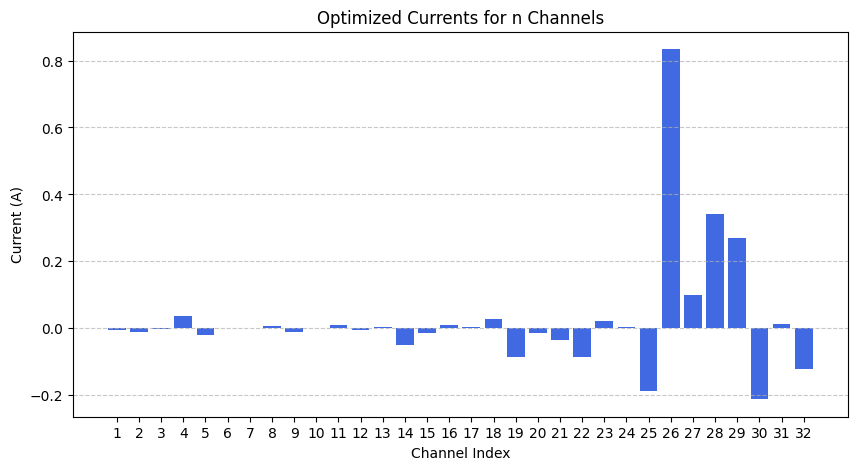

In [68]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(shim_currents) + 1), shim_currents, color='royalblue')

plt.xlabel("Channel Index")
plt.ylabel("Current (A)")
plt.title("Optimized Currents for n Channels")
plt.xticks(range(1, len(shim_currents) + 1)) 

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [69]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display

# ==== 切面函数与最大索引 ====
views = {
    'Axial (Z)': lambda vol, idx: vol[:, :, idx],
    'Coronal (Y)': lambda vol, idx: vol[:, idx, :],
    'Sagittal (X)': lambda vol, idx: vol[idx, :, :]
}


max_indices = {
    'Axial (Z)': target_shape[2] - 1,
    'Coronal (Y)': target_shape[1] - 1,
    'Sagittal (X)': target_shape[0] - 1
}

# ==== 创建滑块 ====
sliders = {
    direction: widgets.IntSlider(value=dim // 2, min=0, max=dim - 1, description=direction.split()[0], continuous_update=False)
    for direction, dim in max_indices.items()
}

# ==== 交互绘图 ====
def plot_interactive(axial_idx, coronal_idx, sagittal_idx):
    slice_indices = {
        'Axial (Z)': axial_idx,
        'Coronal (Y)': coronal_idx,
        'Sagittal (X)': sagittal_idx
    }

    n_views = len(views)
    n_rows = len(results) + 1  # +1 for reference
    plt.figure(figsize=(4 * n_views, 3 * n_rows))

    # 第一行：参考目标场
    for j, (view_name, slicer) in enumerate(views.items()):
        idx = slice_indices[view_name]
        plt.subplot(n_rows, n_views, j + 1)
        plt.imshow(slicer(B0_target, idx).T, cmap='jet', vmin=-300, vmax=300, origin='lower')
        plt.title(f"Ref - {view_name}")
        plt.colorbar()

    # 后续行：不同目标函数下的优化残差
    for i, (name, data) in enumerate(results.items()):
        res_3d = data['residual']  # 已经是 3D array
        for j, (view_name, slicer) in enumerate(views.items()):
            idx = slice_indices[view_name]
            plt.subplot(n_rows, n_views, (i + 1) * n_views + j + 1)
            plt.imshow(slicer(res_3d, idx).T, cmap='jet', vmin=-300, vmax=300, origin='lower')
            plt.title(f"{name} - {view_name}")
            plt.colorbar()

    plt.tight_layout()
    plt.show()

# ==== 显示滑块 UI ====
ui = widgets.VBox([widgets.HBox(list(sliders.values()))])
out = widgets.interactive_output(plot_interactive, {
    'axial_idx': sliders['Axial (Z)'],
    'coronal_idx': sliders['Coronal (Y)'],
    'sagittal_idx': sliders['Sagittal (X)']
})

display(ui, out)


Output()